# Model Evaluation - Logistc Regression and Random Forest Classifier

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to use LogReg and DT. It does not yet use the new features.

# Table of Contents

### - [Staley Logistic Regression](#st16)

### - [Random Forest](#RF)

In [3]:
# assign seed now for consistency any time it needs to be used
seed=27

In [92]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, f1_score, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix

## Read in Staley Raw Data
    - nulls already excluded

In [162]:
staley_data = pd.read_csv("../../data/ofr20161106-na-omit.csv")
staley_data

,Fire Name,Year,Fire_ID,Fire_SegID,Database,State,UTM_Zone,UTM_X,UTM_Y,Response,...,Peak_I15_mm/h,Peak_I30_mm/h,Peak_I60_mm/h,ContributingArea_km2,PropHM23,dNBR/1000,KF,Acc015_mm,Acc030_mm,Acc060_mm
0,Buckweed,2007,bck,bck_1035,Training,CA,11,368133.5165,3823231.989,0,...,3.2,2.0,2.0,0.378767,0.217933,0.297853,0.250000,0.80,1.0,2.0
1,Buckweed,2007,bck,bck_1090,Training,CA,11,367871.0165,3822984.489,0,...,3.2,2.0,2.0,0.689615,0.061249,0.224896,0.250000,0.80,1.0,2.0
2,Buckweed,2007,bck,bck_1570,Training,CA,11,367503.5165,3821741.989,0,...,3.2,2.0,2.0,2.757312,0.042968,0.065537,0.248541,0.80,1.0,2.0
3,Buckweed,2007,bck,bck_235,Training,CA,11,371108.5165,3824991.989,0,...,1.6,1.2,0.8,0.613415,0.092164,0.141711,0.250000,0.40,0.6,0.8
4,Buckweed,2007,bck,bck_363,Training,CA,11,370763.5165,3824576.989,0,...,1.6,1.2,0.8,0.538875,0.058353,0.210158,0.250000,0.40,0.6,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,Wallow,2011,wlw,wlw_45357,Test,AZ,12,660343.3581,3727458.835,0,...,63.0,54.0,39.0,1.819213,0.066777,0.373291,0.000000,15.75,27.0,39.0
1087,Wallow,2011,wlw,wlw_45553,Test,AZ,12,660408.3581,3727358.835,0,...,63.0,54.0,39.0,2.325559,0.115890,0.604177,0.000000,15.75,27.0,39.0
1088,Wallow,2011,wlw,wlw_46217,Test,AZ,12,661118.3581,3727658.835,1,...,63.0,54.0,39.0,0.715387,0.112607,0.428204,0.000000,15.75,27.0,39.0
1089,Wallow,2011,wlw,wlw_47409,Test,AZ,12,660698.3581,3725248.835,1,...,63.0,54.0,39.0,1.554356,0.009801,0.187053,0.000000,15.75,27.0,39.0


## Staley 16 <a id="st16">
recreate Staley's Logistic Regression and calculate model evaluation metrics

In [163]:
#computing input data just as in Staley'16
staley_data["PropHM23_x_i15"] = staley_data["PropHM23"] * staley_data["Acc015_mm"]
staley_data["dNBR_x_i15"] = staley_data["dNBR/1000"] * staley_data["Acc015_mm"]
staley_data["KF_x_i15"] = staley_data["KF"] * staley_data["Acc015_mm"]

use_cols=["PropHM23_x_i15",
          "dNBR_x_i15", 
          "KF_x_i15",
          "Response",
          "Database",
         ]
staley_data = staley_data[use_cols]
staley_data

,PropHM23_x_i15,dNBR_x_i15,KF_x_i15,Response,Database
0,0.174346,0.238282,0.200000,0,Training
1,0.048999,0.179916,0.200000,0,Training
2,0.034374,0.052430,0.198832,0,Training
3,0.036866,0.056684,0.100000,0,Training
4,0.023341,0.084063,0.100000,0,Training
...,...,...,...,...,...
1086,1.051739,5.879331,0.000000,0,Test
1087,1.825272,9.515783,0.000000,0,Test
1088,1.773559,6.744213,0.000000,1,Test
1089,0.154359,2.946077,0.000000,1,Test


In [164]:
# Split based on Staley criteria (trained on SoCal sites)
X_train = staley_data[staley_data['Database'] == 'Training'].iloc[:,:3]
y_train = staley_data[staley_data['Database'] == 'Training'].iloc[:,3]

X_test = staley_data[staley_data['Database'] == 'Test'].iloc[:,:3]
y_test = staley_data[staley_data['Database'] == 'Test'].iloc[:,3]

Training accuracy: 0.8266494178525227
Test accuracy: 0.6257861635220126
Test Recall: 0.7671232876712328


F1 Score (test): 0.48484848484848486


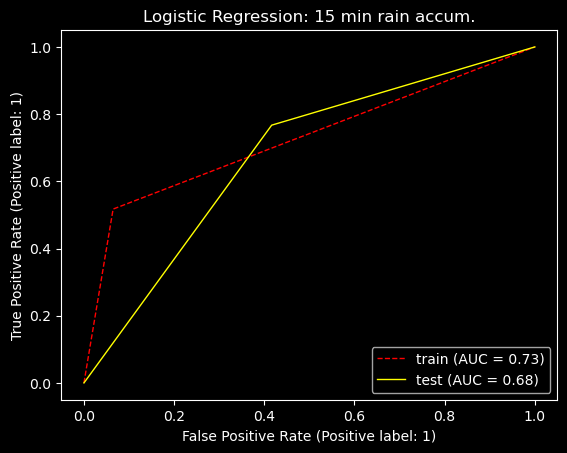

In [165]:
# SoCal train

# instantiate and fit model on training data
clf = LogisticRegression(random_state=seed, penalty='l2').fit(X_train, y_train)

# predict training data
y_train_pred = clf.predict(X_train)

# predict testing data
y_test_pred = clf.predict(X_test)

# accuracy
train_pred_correct = sum(y_train == y_train_pred)
train_accuracy = (train_pred_correct / y_train.shape[0])
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test == y_test_pred)
test_accuracy = (test_pred_correct / y_test.shape[0])
print(f'Test accuracy: {test_accuracy}')

test_recall_score = recall_score(y_test, np.round(y_test_pred), average='binary')
print(f'Test Recall: {test_recall_score}')

# f1
f1_output = f1_score(y_test, y_test_pred)
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train, 
                                 y_train_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test, 
                                 y_test_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('Logistic Regression: 15 min rain accum.');

In [166]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.values, columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = pd.DataFrame(y_test_proba)[1]

# the confusion matrix is pretty bad
# a lot of false negatives
cm = test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()
cm['total'] = cm.sum(axis=1)
cm

pred_correct,False,True,total
y_test,,,
0,102,143,245
1,17,56,73


In [167]:
# this is the complement to recall
false_neg_rate = cm.iloc[1,0] / cm.iloc[1,2]
false_neg_rate

0.2328767123287671

In [179]:
# this is lazy but effective
# reload back the full df
staley_data = pd.read_csv("../../data/ofr20161106-na-omit.csv")

# check geographical distribution of test set labels
staley_data.loc[y_test.index,'pred_correct'] = y_test == y_test_pred

staley_data.groupby(['State'])['pred_correct'].value_counts(normalize=False).unstack().fillna(0)#.style.format("{:,.1%}")

pred_correct,False,True
State,,
AZ,44,40
CO,62,120
NM,13,39


In [187]:
y_test.sum()

73

In [188]:
staley_data[staley_data['Response'] == 1].groupby(['State'])['pred_correct'].value_counts().unstack() / y_test.sum()

pred_correct,False,True
State,,
AZ,0.041096,0.054795
CO,0.178082,0.246575
NM,0.013699,0.465753


In [178]:
staley_data.groupby(['State'])['pred_correct'].sum()

State
AZ     40
CA      0
CO    120
NM     39
Name: pred_correct, dtype: object

## Random Forest Classifier <a id="RF">

### TASK LIST
- The data preparation notebooks I pushed to the repository contain more processing steps including a train-test split on a site basis and randomization of precipitation values which I found helpful. I recommend you use these steps as well.

In [147]:
df = modelDataI=gpd.read_parquet("../../data/staley16_observations_catchment_fuelpars_rocktype_randn_lndslide_fireinterval_v6.parquet")
print('raw data -',df.shape)
df=df.dropna()
print('after nulls removed -',df.shape)

raw data - (1379, 49)
after nulls removed - (1078, 49)


In [148]:
features_15 = [
    'peak_i15_mmh',
    # 'peak_i30_mmh', 
    # 'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    'acc015_mm',
    # 'acc030_mm', 
    # 'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL',
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated',
    # 'dom', # this is encoded as proportion of grass
    # 'domrt', # this is encoded as proportion of rock
    'LNDS_RISKS',
    'fire_interval',
]

Training accuracy: 1.0
Test accuracy: 0.8657407407407407
Test Recall: 0.5660377358490566


F1 Score (test): 0.6741573033707865


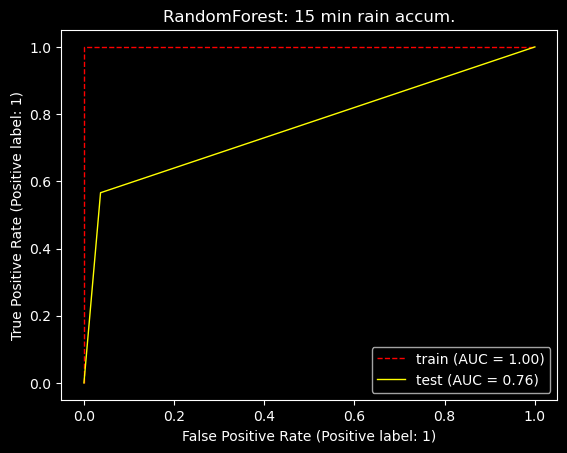

In [149]:
# 15 MIN

# Load data
#data = pd.read_csv('../../data/ofr20161106-na-omit-feat-15.csv')
data = df.copy()
X = data[features_15] # input features
y = data['response'] # debris flow bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scale the data X_train and X_test
cols = X_train.columns
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

# instantiate and fit model on training data
clf = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

# predict training data
y_train_pred = clf.predict(X_train)

# predict testing data
y_test_pred = clf.predict(X_test)

# store probabilities
y_train_proba = clf.predict_proba(X_train)
y_test_proba = clf.predict_proba(X_test)


# accuracy
train_pred_correct = sum(y_train == y_train_pred)
train_accuracy = (train_pred_correct / y_train.shape[0])
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test == y_test_pred)
test_accuracy = (test_pred_correct / y_test.shape[0])
print(f'Test accuracy: {test_accuracy}')

test_recall_score = recall_score(y_test, np.round(y_test_pred), average='binary')
print(f'Test Recall: {test_recall_score}')

# f1
f1_output = f1_score(y_test, y_test_pred)
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train, 
                                 y_train_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test, 
                                 y_test_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('RandomForest: 15 min rain accum.');

In [150]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.values, columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = pd.DataFrame(y_test_proba)[1]

# the confusion matrix is pretty bad
# a lot of false negatives
cm = test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()
cm['total'] = cm.sum(axis=1)
cm

pred_correct,False,True,total
y_test,,,
0,6,157,163
1,23,30,53


In [151]:
# this is the complement to recall
false_neg_rate = cm.iloc[1,0] / cm.iloc[1,2]
false_neg_rate

0.4339622641509434

In [152]:
recall_score(y_test, np.round(y_test_pred), average='binary')

0.5660377358490566

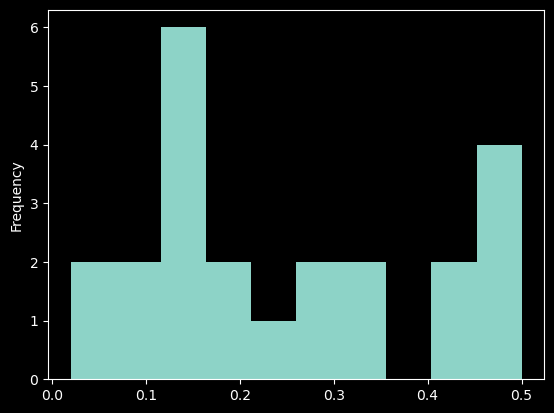

In [153]:
# let's examine the probability of these false negatives
false_negatives = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]
false_negatives['y_test_pred_proba'].plot(kind='hist');

In [170]:
# check geographical distribution of test set labels
data.loc[y_test.index,'pred_correct'] = y_test == y_test_pred

data[data['response']==1].groupby(['state'])['pred_correct'].value_counts(normalize=True).unstack().fillna(0).style.format("{:,.1%}")

KeyError: '[36, 37, 38, 39, 42, 44, 45, 51, 55, 58, 59, 62, 63, 64, 74, 75, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 174, 177, 180, 183, 215, 219, 220, 223, 226, 229, 232, 241, 244, 507, 1028, 1030, 1032, 1035, 1036, 1037, 1038, 1087, 1089] not in index'

In [177]:
data[data['pred_correct'] == False].groupby(['response'])['state'].value_counts().unstack().T.fillna(0)

response,0,1
state,,
AZ,0.0,2.0
CA,6.0,17.0
CO,0.0,4.0


In [172]:
data[data['response']==1].groupby(['state'])['pred_correct'].value_counts(normalize=False).unstack().fillna(0)#.style.format("{:,.1%}")

pred_correct,False,True
state,,
AZ,2.0,0.0
CA,17.0,20.0
CO,4.0,1.0
NM,0.0,9.0


Training accuracy: 0.9977064220183486
Test accuracy: 0.8584474885844748


F1 Score (test): 0.6930693069306931


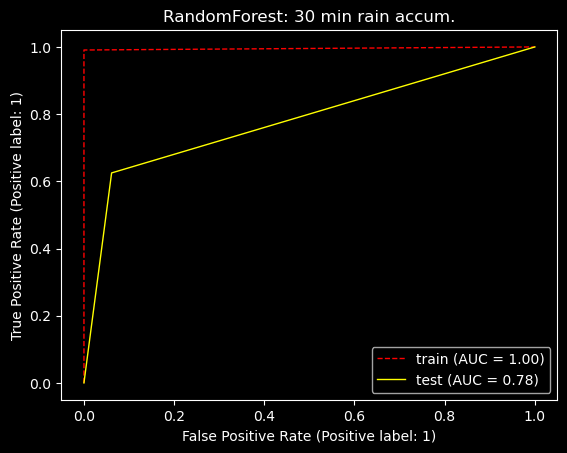

In [19]:
# 30 MIN

# Load data
data = pd.read_csv('../../data/ofr20161106-na-omit-feat-30.csv')
X = data.iloc[:, :4] # input features
y = data.iloc[:, 4] # debris flow bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# instantiate and fit model on training data
clf = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

# predict training data
y_train_pred = clf.predict(X_train)

# predict testing data
y_test_pred = clf.predict(X_test)

# store probabilities
y_train_proba = clf.predict_proba(X_train)
y_test_proba = clf.predict_proba(X_test)


# accuracy
train_pred_correct = sum(y_train == y_train_pred)
train_accuracy = (train_pred_correct / y_train.shape[0])
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test == y_test_pred)
test_accuracy = (test_pred_correct / y_test.shape[0])
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, y_test_pred)
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train, 
                                 y_train_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test, 
                                 y_test_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('RandomForest: 30 min rain accum.');

Training accuracy: 1.0
Test accuracy: 0.867579908675799


F1 Score (test): 0.7010309278350515


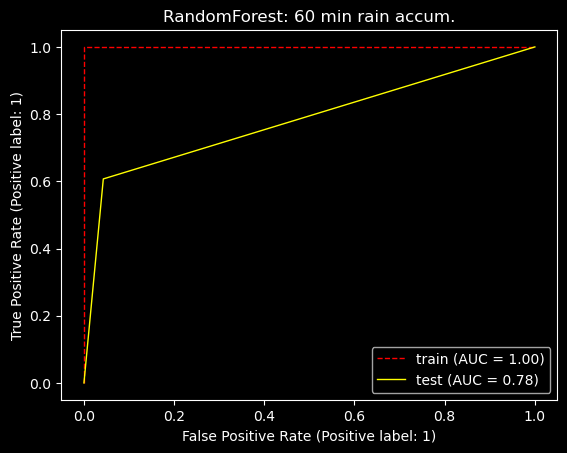

In [20]:
# 60 MIN

# Load data
data = pd.read_csv('../../data/ofr20161106-na-omit-feat-60.csv')
X = data.iloc[:, :4] # input features
y = data.iloc[:, 4] # debris flow bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# instantiate and fit model on training data
clf = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

# predict training data
y_train_pred = clf.predict(X_train)

# predict testing data
y_test_pred = clf.predict(X_test)

# store probabilities
y_train_proba = clf.predict_proba(X_train)
y_test_proba = clf.predict_proba(X_test)


# accuracy
train_pred_correct = sum(y_train == y_train_pred)
train_accuracy = (train_pred_correct / y_train.shape[0])
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test == y_test_pred)
test_accuracy = (test_pred_correct / y_test.shape[0])
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, y_test_pred)
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train, 
                                 y_train_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test, 
                                 y_test_pred,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('RandomForest: 60 min rain accum.');